## Strategies to Think about

- 1st derivative analysis of peaks to determine when to sell and buy
- Fast fourier transform to estimate harmonic osscilations in the market over short timespans
- Rolling averages, seem to be widely use
- Explore machine learning algorithms


In [109]:
# Standard Library Imports
from datetime import datetime, timedelta

# Third party Imports
import pytz
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.linalg import solve
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from scipy.optimize import minimize
from scipy.signal import savgol_filter

# Alpaca Imports
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical import CryptoHistoricalDataClient

## Investment Data and information


In [110]:
# Time Specifications for data
resolution = 10  # minutes
time_frame = TimeFrame(resolution, TimeFrameUnit("Min"))
time_length = 10  # days
start_time = datetime.now(pytz.utc) - timedelta(days=time_length)
end_time = datetime.now(pytz.utc)

symbols = ["BTC/USD"]

investment = 10000  # dollars
initial_investment = investment

## API call for current and historic data


In [111]:
# No keys required for crypto data
client = CryptoHistoricalDataClient()

# Creating request object
request_params = CryptoBarsRequest(
    symbol_or_symbols=symbols,
    timeframe=time_frame,
    start=start_time,
    end=end_time,
)

# Retrieve daily bars for Bitcoin in a DataFrame and printing it
btc_bars = client.get_crypto_bars(request_params)

# Convert to dataframe
btc_data = btc_bars.df.reset_index()

In [112]:
btc_data

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,BTC/USD,2025-03-24 02:30:00+00:00,85743.6000,85799.2435,85675.8300,85722.558,0.000664,2.0,85777.992656
1,BTC/USD,2025-03-24 02:40:00+00:00,85752.7950,85848.9250,85745.4300,85848.925,0.000000,0.0,85754.029750
2,BTC/USD,2025-03-24 02:50:00+00:00,85896.3850,85961.3275,85846.6630,85876.730,0.000000,0.0,85871.524000
3,BTC/USD,2025-03-24 03:00:00+00:00,85881.5450,86182.8105,85881.5450,86079.663,0.000000,0.0,85904.220250
4,BTC/USD,2025-03-24 03:10:00+00:00,86139.9110,86305.1200,86113.4650,86305.120,0.001490,1.0,86211.270000
...,...,...,...,...,...,...,...,...,...
1433,BTC/USD,2025-04-03 01:40:00+00:00,83547.2600,83838.2525,83502.7000,83743.660,0.000000,0.0,83524.980000
1434,BTC/USD,2025-04-03 01:50:00+00:00,83807.3385,83920.0000,83750.7080,83750.708,0.000000,0.0,83807.338500
1435,BTC/USD,2025-04-03 02:00:00+00:00,83817.1550,83873.7700,83574.4450,83615.081,0.000000,0.0,83817.155000
1436,BTC/USD,2025-04-03 02:10:00+00:00,83672.1900,83862.4700,83400.3250,83404.950,0.011532,1.0,83740.480000


In [113]:
from alpaca.data.requests import CryptoLatestQuoteRequest

quote_request = CryptoLatestQuoteRequest(symbol_or_symbols=["BTC/USD"])
latest_quote = client.get_crypto_latest_quote(quote_request)

print(f"Bid: {latest_quote['BTC/USD'].bid_price}, Ask: {latest_quote['BTC/USD'].ask_price}")


Bid: 83423.01, Ask: 83520.2


In [114]:
# fig = go.Figure(
#     data=[go.Candlestick(x=btc_data['timestamp'],
#     open=btc_data['open'],
#     high=btc_data['high'],
#     low=btc_data['low'],
#     close=btc_data['close'])]
# )

# fig.update_layout(
#     width=1500,  # Set the width in pixels
#     height=600 # Set the height in pixels
# )

# fig.update_layout(
#     title={
#         'text': f"Candlestick Plot with {resolution} minute Resolution, Starting on {start_time.strftime('%Y-%m-%d %H:%M')}",
#         'x': 0.5,
#         'xanchor': 'center',
#         'y': 0.9,
#         'yanchor': 'top'
#     }
# )

# fig.show()

### First Derivative of market data


In [115]:
first_deriv = savgol_filter(btc_data["close"], window_length=60, polyorder=3, deriv=1)
btc_data["First Derivative"] = first_deriv

In [116]:
# fig = px.line(btc_data, x='timestamp', y='First Derivative')
# fig.update_layout(
#     title={
#         'text': f"First Derivative Plot with {resolution} minute Resolution, Starting on {start_time.strftime('%Y-%m-%d %H:%M')}",
#         'x': 0.5,
#         'xanchor': 'center',
#         'y': 0.9,
#         'yanchor': 'top'
#     }
# )
# fig.show()

In [117]:
def one_sided_savitzky_golay(y, window_length, polyorder, deriv=0):
    """
    Applies a one-sided Savitzky-Golay filter to the input array.

    Args:
        y (np.ndarray): The input array to filter.
        window_length (int): The size of the filter window (must be odd).
        polyorder (int): The polyorder of the polynomial to fit.
        deriv (int, optional): The polyorder of the deriv to compute 
                                     (default is 0 for smoothing).

    Returns:
        np.ndarray: The filtered array or deriv.
    """
    if window_length % 2 != 1 or window_length < 1:
        raise ValueError("Window size must be a positive odd number")
    if window_length < polyorder + 1:
        raise ValueError("Window size is too small for the polynomial polyorder")

    half_window = (window_length - 1) // 2
    
    # Construct the Vandermonde design matrix
    x = np.arange(window_length)
    V = np.stack([x**i for i in range(polyorder + 1)], axis=1)
    
    # Calculate filter coefficients
    try:
        coeffs = solve(V.T @ V, V.T)
    except np.linalg.LinAlgError:
         raise ValueError("Singular matrix: try decreasing polynomial polyorder or window size")

    # Extract the deriv coefficients
    if deriv > polyorder:
        raise ValueError("deriv polyorder is too high for the polynomial polyorder")
    
    deriv_coeffs = coeffs[deriv]
    
    # Apply the filter to each point, considering the one-sided window
    filtered_values = np.zeros_like(y)
    for i in range(len(y)):
        start = max(0, i - window_length + 1)
        end = i + 1
        window = y[start:end]
        
        if len(window) < window_length:
            pad_size = window_length - len(window)
            padded_window = np.pad(window, (pad_size, 0), 'edge')
            filtered_values[i] = np.dot(deriv_coeffs, padded_window)
        else:
            filtered_values[i] = np.dot(deriv_coeffs, window)
            
    return filtered_values

## Mean Reversion Strategy


In [127]:
first_resolution = 0.05*int(60 / resolution) * 24  # minute
second_resolution = 3 * int(60 / resolution) * 24  # minute

btc_data["Moving Avg (Hour)"] = btc_data["close"].rolling(int(first_resolution)).mean()
btc_data["Moving Avg (Hour) STD"] = btc_data["close"].rolling(int(first_resolution)).std()
btc_data["Moving Avg (Hour) Deriv"] = savgol_filter(
    btc_data["Moving Avg (Hour)"], window_length=5, polyorder=2, deriv=1
)
dy=np.diff(btc_data["Moving Avg (Hour)"],1)
dy_ewm = pd.Series(dy).ewm(span=5, adjust=False).mean()
btc_data["Moving Avg (Hour) Deriv Smoothed"] = dy_ewm

btc_data["Moving Avg (Day)"] = btc_data["close"].rolling(second_resolution).mean()
btc_data["Moving Avg (Day) STD"] = btc_data["close"].rolling(second_resolution).std()

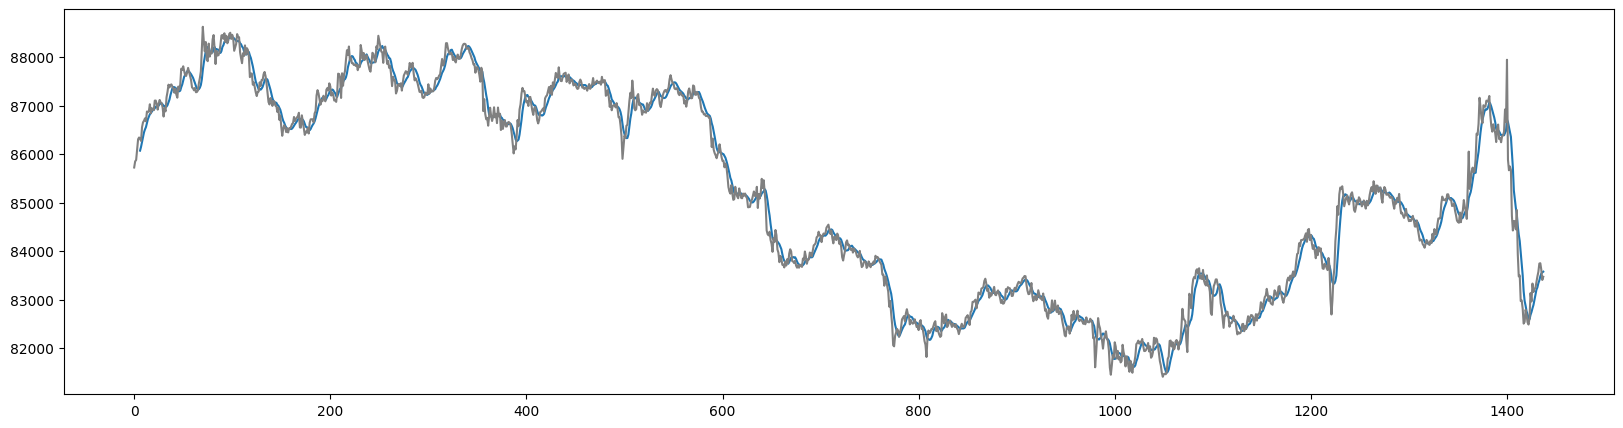

In [128]:
plt.figure(figsize=(20,5))
plt.plot(btc_data["Moving Avg (Hour)"])
plt.plot(btc_data["close"], c="gray")

<BarContainer object of 1438 artists>

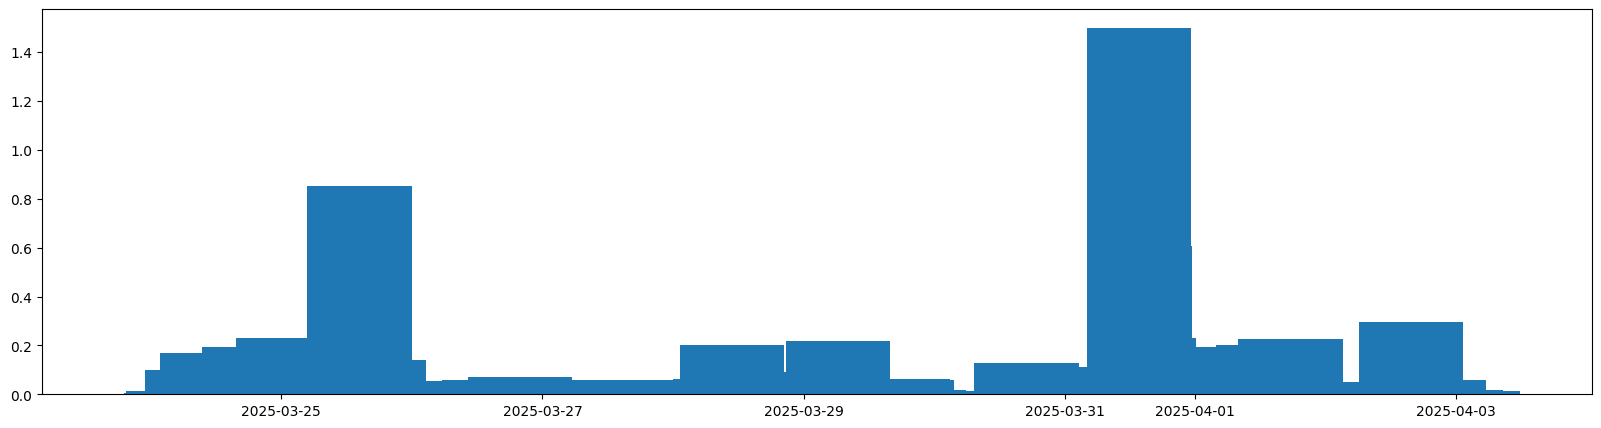

In [138]:
plt.figure(figsize=(20,5))
plt.bar(btc_data["timestamp"], btc_data["volume"])

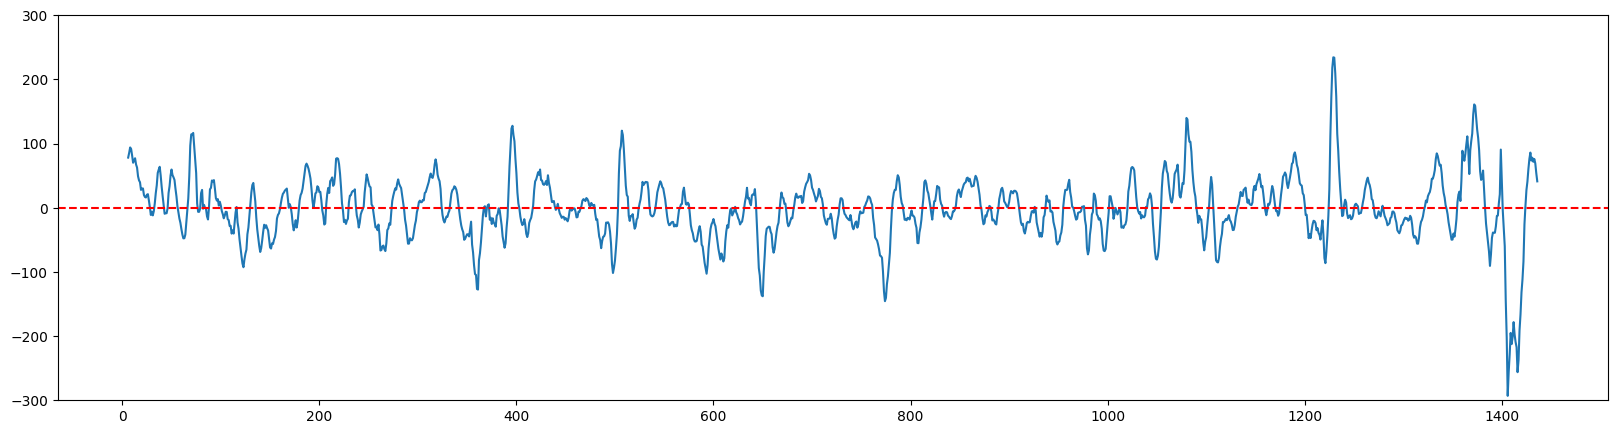

In [129]:
plt.figure(figsize=(20,5))
plt.plot(btc_data["Moving Avg (Hour) Deriv Smoothed"])
plt.ylim(-300,300)
plt.axhline(0, linestyle="--", c="r")

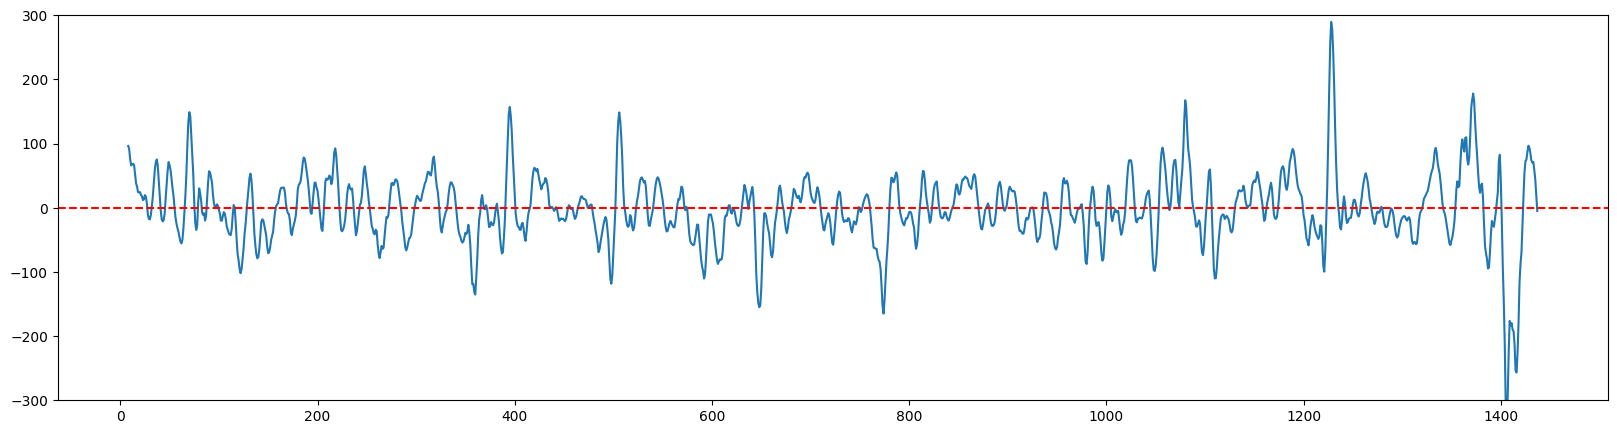

In [130]:
plt.figure(figsize=(20,5))
plt.plot(btc_data["Moving Avg (Hour) Deriv"])
plt.ylim(-300,300)
plt.axhline(0, linestyle="--", c="r")

In [131]:
btc_data

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,First Derivative,Moving Avg (Hour),Moving Avg (Hour) STD,Moving Avg (Hour) Deriv,Moving Avg (Hour) Deriv Smoothed,Moving Avg (Day),Moving Avg (Day) STD
0,BTC/USD,2025-03-24 02:30:00+00:00,85743.6000,85799.2435,85675.8300,85722.558,0.000664,2.0,85777.992656,85.758512,NaN,NaN,NaN,NaN,NaN,NaN
1,BTC/USD,2025-03-24 02:40:00+00:00,85752.7950,85848.9250,85745.4300,85848.925,0.000000,0.0,85754.029750,81.960740,NaN,NaN,NaN,NaN,NaN,NaN
2,BTC/USD,2025-03-24 02:50:00+00:00,85896.3850,85961.3275,85846.6630,85876.730,0.000000,0.0,85871.524000,78.265796,NaN,NaN,NaN,NaN,NaN,NaN
3,BTC/USD,2025-03-24 03:00:00+00:00,85881.5450,86182.8105,85881.5450,86079.663,0.000000,0.0,85904.220250,74.673680,NaN,NaN,NaN,NaN,NaN,NaN
4,BTC/USD,2025-03-24 03:10:00+00:00,86139.9110,86305.1200,86113.4650,86305.120,0.001490,1.0,86211.270000,71.184391,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,BTC/USD,2025-04-03 01:40:00+00:00,83547.2600,83838.2525,83502.7000,83743.660,0.000000,0.0,83524.980000,150.955638,83396.775214,211.653559,71.619521,76.065186,83863.388931,1412.624471
1434,BTC/USD,2025-04-03 01:50:00+00:00,83807.3385,83920.0000,83750.7080,83750.708,0.000000,0.0,83807.338500,173.822522,83481.610000,218.371264,58.542157,69.167481,83867.930153,1409.088981
1435,BTC/USD,2025-04-03 02:00:00+00:00,83817.1550,83873.7700,83574.4450,83615.081,0.000000,0.0,83817.155000,197.500774,83536.982071,190.562441,43.747629,53.935678,83871.796607,1406.088128
1436,BTC/USD,2025-04-03 02:10:00+00:00,83672.1900,83862.4700,83400.3250,83404.950,0.011532,1.0,83740.480000,221.990393,83560.454143,154.728149,19.419731,41.169500,83875.587056,1402.605052


In [132]:
def mean_reversion_crypto_algo(data: pd.DataFrame, investment, deriv_cutoff):
    orders_dict = {}
    sub_data_dict = {}
    current_key = 0
    has_position = False

    most_profitable_trade_datetime = ""
    most_profitable_trade_amount = -np.inf

    most_unprofitable_trade_datetime = ""
    most_unprofitable_trade_amount = np.inf

    win_len = 15

    

    first_resolution = 0.1*int(60 / resolution) * 24  # minute
    second_resolution = 3 * int(60 / resolution) * 24  # minute

    for idx in range(len(data)):

        if idx-win_len < win_len:
            continue

        sub_data = data.iloc[:idx-1, :].copy()

        sub_data["Moving Avg (Hour)"] = sub_data["close"].rolling(int(first_resolution)).mean()
        sub_data["Moving Avg (Hour) STD"] = sub_data["close"].rolling(int(first_resolution)).std()
        sub_data["Moving Avg (Hour) Deriv"] = savgol_filter(
            sub_data["Moving Avg (Hour)"], window_length=win_len, polyorder=2, deriv=1
        )

        sub_data["Moving Avg (Day)"] = sub_data["close"].rolling(second_resolution).mean()
        sub_data["Moving Avg (Day) STD"] = sub_data["close"].rolling(second_resolution).std()
        
        row = sub_data.iloc[idx-win_len, :]


        if np.isnan(row["Moving Avg (Day)"]):
            continue

        if (
            (row["Moving Avg (Hour)"] > row["Moving Avg (Day)"])
            and not has_position
            and (row["Moving Avg (Hour) Deriv"] > 0)
        ):
            has_position = True
            orders_dict[current_key] = {
                "First Deriv at Purchase": row["Moving Avg (Hour) Deriv"],
                "Order Index": idx-win_len,
                "Order Datetime": row["timestamp"],
                "Order Price": row["close"],
            }

        if has_position:
            if (
                row["Moving Avg (Hour) Deriv"]
                < -orders_dict[current_key]["First Deriv at Purchase"] * deriv_cutoff
            ):
                orders_dict[current_key]["First Deriv at Sell"] = row[
                    "Moving Avg (Hour) Deriv"
                ]
                orders_dict[current_key]["Sell Datetime"] = row["timestamp"]
                orders_dict[current_key]["Sell Price"] = row["close"]
                orders_dict[current_key]["Percent Change"] = (
                    100
                    * (row["close"] - orders_dict[current_key]["Order Price"])
                    / orders_dict[current_key]["Order Price"]
                )
                orders_dict[current_key]["Profit"] = (
                    orders_dict[current_key]["Percent Change"] * investment / 100
                )
                investment += orders_dict[current_key]["Profit"]

                if orders_dict[current_key]["Profit"] > most_profitable_trade_amount:
                    most_profitable_trade_amount = orders_dict[current_key]["Profit"]
                    most_profitable_trade_datetime = orders_dict[current_key][
                        "Order Datetime"
                    ]
                if orders_dict[current_key]["Profit"] < most_unprofitable_trade_amount:
                    most_unprofitable_trade_amount = orders_dict[current_key]["Profit"]
                    most_unprofitable_trade_datetime = orders_dict[current_key][
                        "Order Datetime"
                    ]

                sub_data_dict[idx] = sub_data
                has_position = False
                if orders_dict[current_key]["Profit"] != 0:
                    current_key += 1

    trade_metrics = [
        most_profitable_trade_datetime,
        most_profitable_trade_amount,
        most_unprofitable_trade_datetime,
        most_unprofitable_trade_amount,
    ]
    return orders_dict, trade_metrics, investment, sub_data_dict


orders_dict, trade_metrics, investment, sub_data_ = mean_reversion_crypto_algo(
    btc_data, investment, deriv_cutoff=0.15
)

total_profit = investment - initial_investment
profit_per_day = (investment - initial_investment) / time_length
percent_profit_per_day = total_profit / initial_investment / time_length


print("Trading Results Summary")
print("------------------------------")
print(f"Total Profit: ${total_profit:,.2f}")
print(f"Profit/Day: ${profit_per_day:,.2f}")
print(f"Percent Profit/Day: {100 * percent_profit_per_day:,.3f}%")
print(f"Final Investment: ${investment:,.2f}")
print("------------------------------")
print(
    f"Most Profitable Trade: ${trade_metrics[1]:,.2f}, Order Date: {trade_metrics[0]}"
)
print(
    f"Most Un-Profitable Trade: ${trade_metrics[3]:,.2f}, Order Date: {trade_metrics[2]}"
)


Trading Results Summary
------------------------------
Total Profit: $1,031.03
Profit/Day: $103.10
Percent Profit/Day: 1.031%
Final Investment: $11,031.03
------------------------------
Most Profitable Trade: $216.70, Order Date: 2025-04-02 13:00:00+00:00
Most Un-Profitable Trade: $-42.19, Order Date: 2025-03-31 15:20:00+00:00


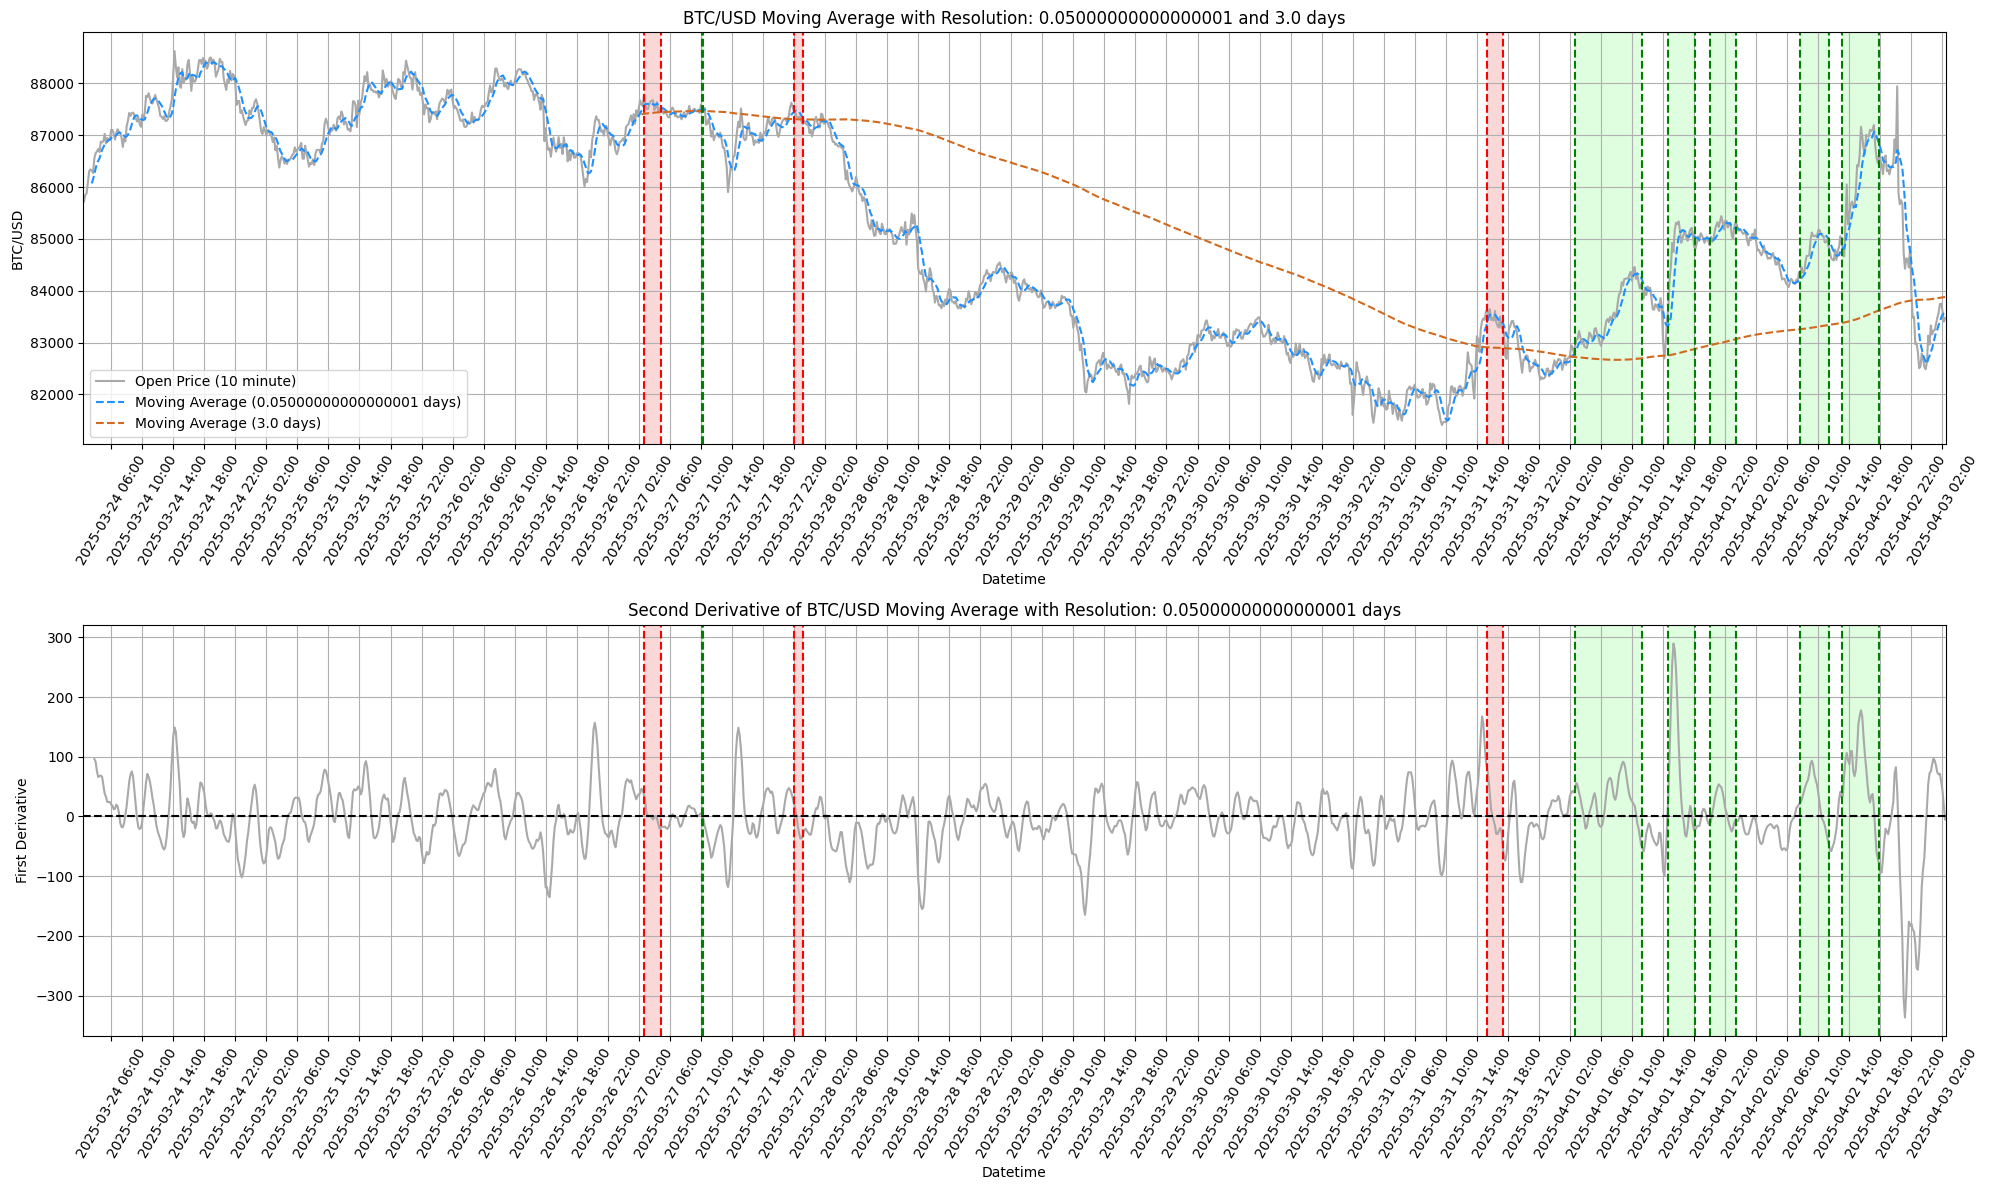

In [133]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))




ax[0].plot(
    btc_data["timestamp"],
    btc_data["close"],
    c="darkgray",
    label=f"Open Price ({resolution} minute)",
)

ax[0].plot(
    btc_data["timestamp"],
    btc_data["Moving Avg (Hour)"],
    c="dodgerblue",
    linestyle="--",
    label=f"Moving Average ({first_resolution / (int(60 / resolution) * 24)} days)",
)
# ax[0].plot(btc_data["timestamp"], btc_data["Moving Avg (Hour)"]+ 2*btc_data["Moving Avg (Hour) STD"], c="lightcoral", linestyle="--", label=f"STD High ({first_resolution/(int(60/resolution)*24)} days)")
# ax[0].plot(btc_data["timestamp"], btc_data["Moving Avg (Hour)"]- 2*btc_data["Moving Avg (Hour) STD"], c="lightcoral", linestyle="--", label=f"STD Low ({first_resolution/(int(60/resolution)*24)} days)")

ax[0].plot(
    btc_data["timestamp"],
    btc_data["Moving Avg (Day)"],
    c="chocolate",
    linestyle="--",
    label=f"Moving Average ({second_resolution / (int(60 / resolution) * 24)} days)",
)
# ax[0].plot(btc_data["timestamp"], btc_data["Moving Avg (Day)"]+ 2*btc_data["Moving Avg (Day) STD"], c="palegreen", linestyle="--", label=f"STD High ({second_resolution/(int(60/resolution)*24)} days)")
# ax[0].plot(btc_data["timestamp"], btc_data["Moving Avg (Day)"]- 2*btc_data["Moving Avg (Day) STD"], c="palegreen", linestyle="--", label=f"STD Low ({second_resolution/(int(60/resolution)*24)} days)")

ax[0].grid()
ax[0].legend()
ax[0].set_xlim(start_time, end_time)
ax[0].set_xlabel("Datetime")
ax[0].set_ylabel(f"{symbols[0]}")
ax[0].set_title(
    f"{symbols[0]} Moving Average with Resolution: {first_resolution / (int(60 / resolution) * 24)} and {second_resolution / (int(60 / resolution) * 24)} days"
)
axis_interval = int(time_length/20) if time_length/20 > 1  else 1
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=axis_interval))
ax[0].tick_params(axis="x", labelrotation=60)


ax[1].plot(
    btc_data["timestamp"],
    btc_data["Moving Avg (Hour) Deriv"],
    c="darkgray",
    label=f"Moving Average ({first_resolution / (int(60 / resolution) * 24)} days)",
)
ax[1].axhline(0, linestyle="--", c="k")

ax[1].grid()
ax[1].set_xlim(start_time, end_time)
ax[1].set_xlabel("Datetime")
ax[1].set_ylabel("First Derivative")
ax[1].set_title(
    f"Second Derivative of {symbols[0]} Moving Average with Resolution: {first_resolution / (int(60 / resolution) * 24)} days"
)
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=axis_interval))
ax[1].tick_params(axis="x", labelrotation=60)

for key, data in orders_dict.items():
    try:
        if data["Profit"] >= 0:
            ax[0].axvline(data["Order Datetime"], linestyle="--", c="green")
            ax[1].axvline(data["Order Datetime"], linestyle="--", c="green")
            ax[0].axvline(data["Sell Datetime"], linestyle="--", c="green")
            ax[1].axvline(data["Sell Datetime"], linestyle="--", c="green")
            ax[0].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="palegreen",
                alpha=0.3,
            )
            ax[1].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="palegreen",
                alpha=0.3,
            )
        else:
            ax[0].axvline(data["Order Datetime"], linestyle="--", c="red")
            ax[1].axvline(data["Order Datetime"], linestyle="--", c="red")
            ax[0].axvline(data["Sell Datetime"], linestyle="--", c="red")
            ax[1].axvline(data["Sell Datetime"], linestyle="--", c="red")
            ax[0].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="lightcoral",
                alpha=0.3,
            )
            ax[1].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="lightcoral",
                alpha=0.3,
            )
    except KeyError:
        ax[0].axvline(data["Order Datetime"], linestyle="--", c="green")
        ax[1].axvline(data["Order Datetime"], linestyle="--", c="green")

# Set x-axis to display hour ticks
hours = mdates.HourLocator(interval=4)  # Ticks every hour
h_fmt = mdates.DateFormatter('%Y-%m-%d %H:%M')  # Format as HH:MM

ax[0].xaxis.set_major_locator(hours)
ax[0].xaxis.set_major_formatter(h_fmt)

ax[1].xaxis.set_major_locator(hours)
ax[1].xaxis.set_major_formatter(h_fmt)

fig.tight_layout()

In [134]:
btc_data

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,First Derivative,Moving Avg (Hour),Moving Avg (Hour) STD,Moving Avg (Hour) Deriv,Moving Avg (Hour) Deriv Smoothed,Moving Avg (Day),Moving Avg (Day) STD
0,BTC/USD,2025-03-24 02:30:00+00:00,85743.6000,85799.2435,85675.8300,85722.558,0.000664,2.0,85777.992656,85.758512,NaN,NaN,NaN,NaN,NaN,NaN
1,BTC/USD,2025-03-24 02:40:00+00:00,85752.7950,85848.9250,85745.4300,85848.925,0.000000,0.0,85754.029750,81.960740,NaN,NaN,NaN,NaN,NaN,NaN
2,BTC/USD,2025-03-24 02:50:00+00:00,85896.3850,85961.3275,85846.6630,85876.730,0.000000,0.0,85871.524000,78.265796,NaN,NaN,NaN,NaN,NaN,NaN
3,BTC/USD,2025-03-24 03:00:00+00:00,85881.5450,86182.8105,85881.5450,86079.663,0.000000,0.0,85904.220250,74.673680,NaN,NaN,NaN,NaN,NaN,NaN
4,BTC/USD,2025-03-24 03:10:00+00:00,86139.9110,86305.1200,86113.4650,86305.120,0.001490,1.0,86211.270000,71.184391,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,BTC/USD,2025-04-03 01:40:00+00:00,83547.2600,83838.2525,83502.7000,83743.660,0.000000,0.0,83524.980000,150.955638,83396.775214,211.653559,71.619521,76.065186,83863.388931,1412.624471
1434,BTC/USD,2025-04-03 01:50:00+00:00,83807.3385,83920.0000,83750.7080,83750.708,0.000000,0.0,83807.338500,173.822522,83481.610000,218.371264,58.542157,69.167481,83867.930153,1409.088981
1435,BTC/USD,2025-04-03 02:00:00+00:00,83817.1550,83873.7700,83574.4450,83615.081,0.000000,0.0,83817.155000,197.500774,83536.982071,190.562441,43.747629,53.935678,83871.796607,1406.088128
1436,BTC/USD,2025-04-03 02:10:00+00:00,83672.1900,83862.4700,83400.3250,83404.950,0.011532,1.0,83740.480000,221.990393,83560.454143,154.728149,19.419731,41.169500,83875.587056,1402.605052


In [135]:
sub_data_[673]

KeyError: 673

In [ ]:
orders_dict

{0: {'First Deriv at Purchase': np.float64(19.04727066309806),
  'Order Index': 541,
  'Order Datetime': Timestamp('2025-03-19 06:40:00+0000', tz='UTC'),
  'Order Price': np.float64(83185.305),
  'First Deriv at Sell': np.float64(-3.4280853318007303),
  'Sell Datetime': Timestamp('2025-03-19 17:40:00+0000', tz='UTC'),
  'Sell Price': np.float64(84034.15),
  'Percent Change': np.float64(1.0204266246303975),
  'Profit': np.float64(102.04266246303975)},
 1: {'First Deriv at Purchase': np.float64(0.25217232125964983),
  'Order Index': 608,
  'Order Datetime': Timestamp('2025-03-19 18:00:00+0000', tz='UTC'),
  'Order Price': np.float64(84081.88),
  'First Deriv at Sell': np.float64(-0.1408778062957481),
  'Sell Datetime': Timestamp('2025-03-20 01:00:00+0000', tz='UTC'),
  'Sell Price': np.float64(86300.225),
  'Percent Change': np.float64(2.638315175635941),
  'Profit': np.float64(266.52372461297944)},
 2: {'First Deriv at Purchase': np.float64(3.225975382481238),
  'Order Index': 683,
  'O

In [ ]:
-orders_dict[7]["First Deriv at Purchase"] * .15

np.float64(-0.3325775701277848)

In [ ]:
btc_data

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,First Derivative,Moving Avg (Hour),Moving Avg (Hour) STD,Moving Avg (Hour) Deriv,Moving Avg (Day),Moving Avg (Day) STD
0,BTC/USD,2025-03-15 03:40:00+00:00,84521.9710,84521.971,84458.530000,84520.3800,0.000000,0.0,84521.971000,-22.233187,NaN,NaN,NaN,NaN,NaN
1,BTC/USD,2025-03-15 03:50:00+00:00,84456.2845,84505.200,84456.284500,84498.8290,0.001714,1.0,84505.200000,-22.931030,NaN,NaN,NaN,NaN,NaN
2,BTC/USD,2025-03-15 04:00:00+00:00,84535.8860,84535.886,84458.472000,84458.4720,0.000000,0.0,84535.886000,-23.554089,NaN,NaN,NaN,NaN,NaN
3,BTC/USD,2025-03-15 04:10:00+00:00,84400.4030,84400.403,84329.535000,84333.0415,0.006000,1.0,84365.970000,-24.102365,NaN,NaN,NaN,NaN,NaN
4,BTC/USD,2025-03-15 04:20:00+00:00,84390.8830,84409.340,84322.110000,84409.3400,0.002803,1.0,84390.883000,-24.575856,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,BTC/USD,2025-03-25 02:40:00+00:00,86968.9400,87013.600,86922.497500,86991.0400,0.000533,1.0,87013.600000,-21.565927,87225.441536,260.273822,-43.122043,85536.550281,1532.180341
1428,BTC/USD,2025-03-25 02:50:00+00:00,86957.9750,86957.975,86866.769500,86866.7695,0.000000,0.0,86957.975000,-20.226888,87169.688143,246.170761,-47.499781,85542.881559,1532.012580
1429,BTC/USD,2025-03-25 03:00:00+00:00,86898.2800,86955.510,86835.546278,86955.5100,0.000000,0.0,86898.280000,-18.827620,87117.119107,200.522530,-51.877519,85549.349534,1532.064679
1430,BTC/USD,2025-03-25 03:10:00+00:00,87014.8800,87014.880,86684.500000,86706.2550,0.040056,3.0,86798.025823,-17.368123,87052.906964,174.434882,-56.255257,85555.169884,1531.671658


In [ ]:
start_time <end_time

True

KeyError: 437

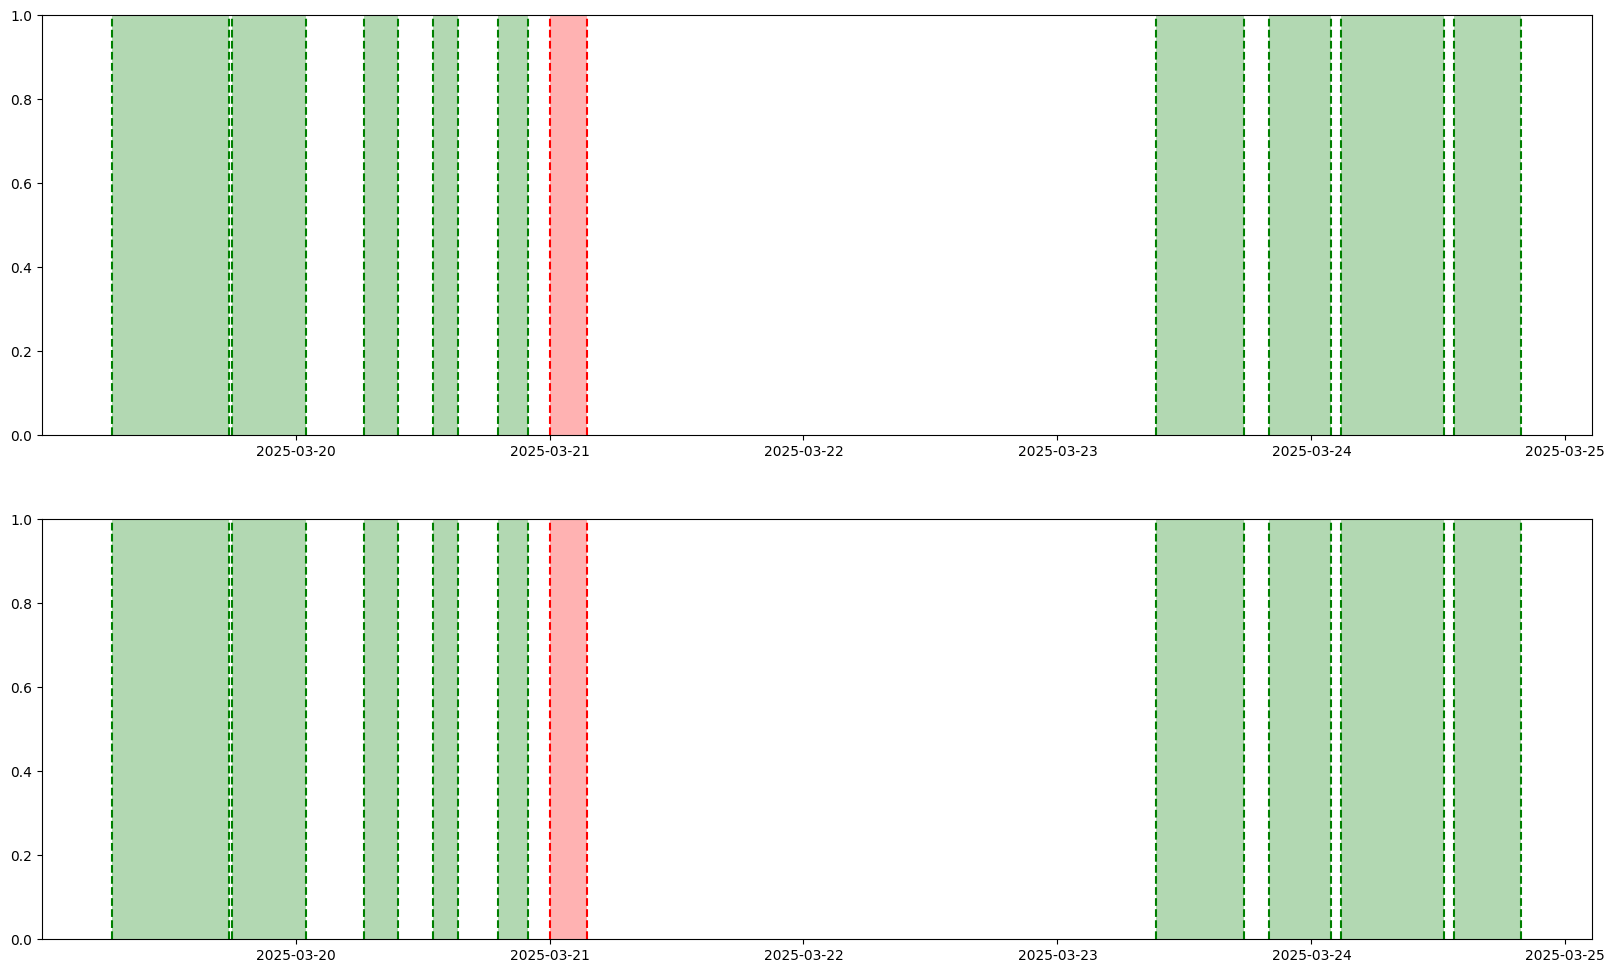

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))

for key, data in orders_dict.items():
    try:
        if data["Profit"] >= 0:
            ax[0].axvline(data["Order Datetime"], linestyle="--", c="g")
            ax[1].axvline(data["Order Datetime"], linestyle="--", c="g")
            ax[0].axvline(data["Sell Datetime"], linestyle="--", c="g")
            ax[1].axvline(data["Sell Datetime"], linestyle="--", c="g")
            ax[0].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="g",
                alpha=0.3,
            )
            ax[1].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="g",
                alpha=0.3,
            )
        else:
            ax[0].axvline(data["Order Datetime"], linestyle="--", c="r")
            ax[1].axvline(data["Order Datetime"], linestyle="--", c="r")
            ax[0].axvline(data["Sell Datetime"], linestyle="--", c="r")
            ax[1].axvline(data["Sell Datetime"], linestyle="--", c="r")
            ax[0].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="r",
                alpha=0.3,
            )
            ax[1].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="r",
                alpha=0.3,
            )
    except KeyError:
        ax[0].axvline(data["Order Datetime"], linestyle="--", c="g")
        ax[1].axvline(data["Order Datetime"], linestyle="--", c="g")


ax[0].plot(
    sub_data_[437]["timestamp"],
    sub_data_[437]["close"],
    c="cornflowerblue",
    label=f"Open Price ({resolution} minute)",
)

ax[0].plot(
    sub_data_[437]["timestamp"],
    sub_data_[437]["Moving Avg (Hour)"],
    c="red",
    linestyle="--",
    label=f"Moving Average ({first_resolution / (int(60 / resolution) * 24)} days)",
)

ax[0].plot(
    sub_data_[437]["timestamp"],
    sub_data_[437]["Moving Avg (Day)"],
    c="lime",
    linestyle="--",
    label=f"Moving Average ({second_resolution / (int(60 / resolution) * 24)} days)",
)

ax[0].grid()
ax[0].legend()
# ax[0].set_xlim(sub_data_[437]["timestamp"].iloc[0], sub_data_[437]["timestamp"].iloc[-1])
ax[0].set_xlim(orders_dict[0]['Order Datetime'], orders_dict[0]['Sell Datetime'])
ax[0].set_xlabel("Datetime")
ax[0].set_ylabel(f"{symbols[0]}")
ax[0].set_title(
    f"{symbols[0]} Moving Average with Resolution: {first_resolution / (int(60 / resolution) * 24)} and {second_resolution / (int(60 / resolution) * 24)} days"
)
axis_interval = int(time_length/20) if time_length/20 > 0  else 1
# ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=axis_interval))
ax[0].tick_params(axis="x", labelrotation=45)


ax[1].plot(
    sub_data_[437]["timestamp"],
    sub_data_[437]["Moving Avg (Hour) Deriv"],
    c="cornflowerblue",
    label=f"Moving Average ({first_resolution / (int(60 / resolution) * 24)} days)",
)
ax[1].axhline(0, linestyle="--", c="k")

ax[1].grid()
# ax[1].set_xlim(sub_data_[437]["timestamp"].iloc[0], sub_data_[437]["timestamp"].iloc[-1])
ax[1].set_xlim(orders_dict[0]['Order Datetime'], orders_dict[0]['Sell Datetime'])
ax[1].set_xlabel("Datetime")
ax[1].set_ylabel("First Derivative")
ax[1].set_title(
    f"Second Derivative of {symbols[0]} Moving Average with Resolution: {first_resolution / (int(60 / resolution) * 24)} days"
)
# ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=axis_interval))
ax[1].tick_params(axis="x", labelrotation=45)

fig.tight_layout()

In [ ]:
sub_data_[437]

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,First Derivative,Moving Avg (Hour),Moving Avg (Hour) STD,Moving Avg (Hour) Deriv,Moving Avg (Day),Moving Avg (Day) STD
0,BTC/USD,2025-03-18 11:20:00+00:00,82769.3775,82769.3775,82696.2175,82696.2175,0.000000,0.0,82769.377500,-96.183978,NaN,NaN,NaN,NaN,NaN
1,BTC/USD,2025-03-18 11:30:00+00:00,82678.7000,82678.7000,82581.8980,82581.8980,0.000000,0.0,82678.700000,-91.813231,NaN,NaN,NaN,NaN,NaN
2,BTC/USD,2025-03-18 11:40:00+00:00,82638.8250,82638.8250,82606.9400,82606.9400,0.000000,0.0,82638.825000,-87.521669,NaN,NaN,NaN,NaN,NaN
3,BTC/USD,2025-03-18 11:50:00+00:00,82536.5665,82631.4700,82536.5665,82573.0300,0.000000,0.0,82536.566500,-83.309294,NaN,NaN,NaN,NaN,NaN
4,BTC/USD,2025-03-18 12:00:00+00:00,82530.4450,82679.3800,82526.3555,82527.5655,0.002724,3.0,82672.259579,-79.176105,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,BTC/USD,2025-03-21 11:20:00+00:00,83977.5485,84011.1750,83942.6980,83958.7550,0.000000,0.0,83977.548500,-5.084921,84268.512354,267.741840,-2.456549,84136.985965,1380.705952
432,BTC/USD,2025-03-21 11:30:00+00:00,83927.5200,84010.6300,83927.5200,83940.4280,0.000000,0.0,83927.520000,-6.703788,84265.444431,270.241294,1.289868,84139.866082,1378.990203
433,BTC/USD,2025-03-21 11:40:00+00:00,84004.1280,84087.0000,83998.9935,84087.0000,0.000000,0.0,84004.128000,-8.600527,84263.666375,270.997830,-0.187069,84143.350115,1376.944659
434,BTC/USD,2025-03-21 11:50:00+00:00,84079.3410,84092.3000,84038.1705,84038.1705,0.000000,0.0,84085.820500,-10.829473,84261.701250,272.126231,-1.542563,84146.663148,1374.959756


In [ ]:
orders_dict[0]['Order Datetime']

Timestamp('2025-03-21 11:30:00+0000', tz='UTC')

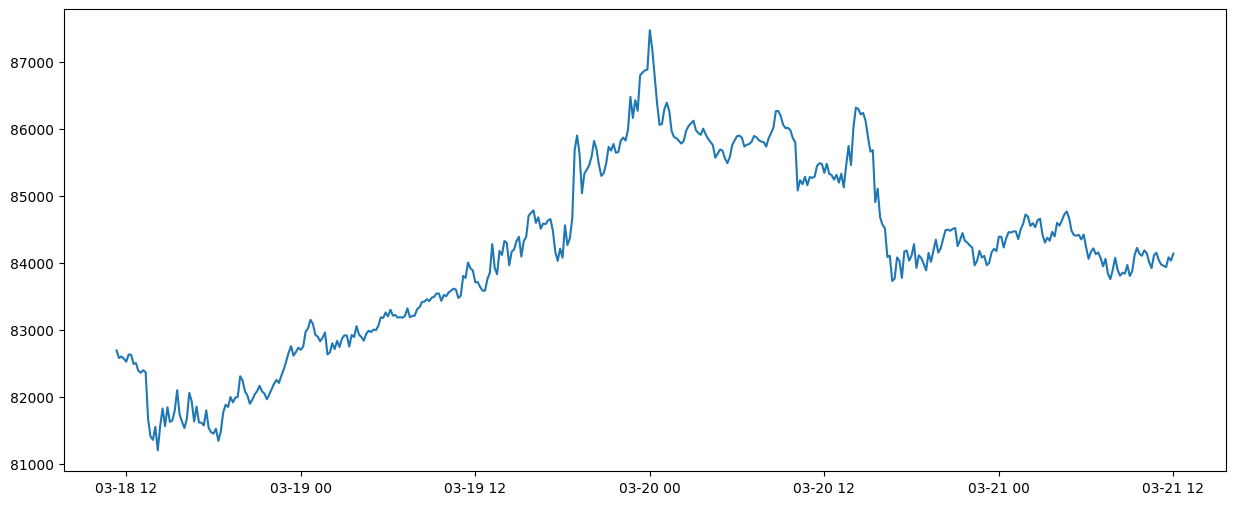

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(sub_data_[437]["timestamp"], sub_data_[437]["close"])

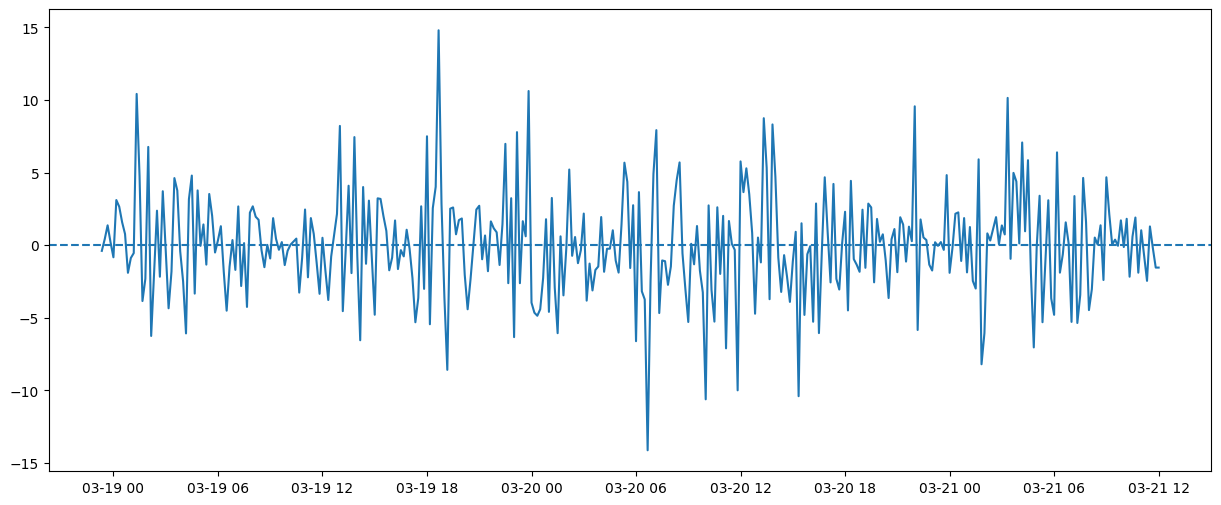

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(sub_data_[437]["timestamp"], sub_data_[437]["Moving Avg (Hour) Deriv"])
plt.axhline(0, linestyle="--")

In [ ]:
sub_data_

{437:       symbol                 timestamp        open        high         low  \
 0    BTC/USD 2025-03-18 11:20:00+00:00  82769.3775  82769.3775  82696.2175   
 1    BTC/USD 2025-03-18 11:30:00+00:00  82678.7000  82678.7000  82581.8980   
 2    BTC/USD 2025-03-18 11:40:00+00:00  82638.8250  82638.8250  82606.9400   
 3    BTC/USD 2025-03-18 11:50:00+00:00  82536.5665  82631.4700  82536.5665   
 4    BTC/USD 2025-03-18 12:00:00+00:00  82530.4450  82679.3800  82526.3555   
 ..       ...                       ...         ...         ...         ...   
 431  BTC/USD 2025-03-21 11:20:00+00:00  83977.5485  84011.1750  83942.6980   
 432  BTC/USD 2025-03-21 11:30:00+00:00  83927.5200  84010.6300  83927.5200   
 433  BTC/USD 2025-03-21 11:40:00+00:00  84004.1280  84087.0000  83998.9935   
 434  BTC/USD 2025-03-21 11:50:00+00:00  84079.3410  84092.3000  84038.1705   
 435  BTC/USD 2025-03-21 12:00:00+00:00  84002.3150  84142.3950  84002.3150   
 
           close    volume  trade_count      

In [ ]:
shortest_trade = np.inf
key_shortest = 0
for key, value in orders_dict.items():
    time_diff = value["Sell Datetime"] - value["Order Datetime"]
    minutes = time_diff.total_seconds()/60
    if minutes < shortest_trade:
        shortest_trade = minutes
        key_shortest = key
print(f"Shortest: {shortest_trade} minutes, Key: {key_shortest}")

Shortest: 20.0 minutes, Key: 0


### Algorithm Parameter Optimization


In [ ]:
# resolution_optimal = 10  # minutes
# first_resolution_days = 1
# second_resolution_days = 5
# filter_length = 15
# cutoff = 0.20

# optimal_params = [
#     resolution_optimal,
#     first_resolution_days,
#     second_resolution_days,
#     filter_length,
#     cutoff,
# ]


# def optimize_algo(optimal_params, investment):

#     # if optimal_params[0] < 1:
#     #     return np.inf

#     # if optimal_params[1] < 1:
#     #     return np.inf

#     # if optimal_params[2] < 2:
#     #     return np.inf

#     # if optimal_params[3] < 3:
#     #     return np.inf

#     # if optimal_params[4] < 0:
#     #     return np.inf

#     # if optimal_params[2] < optimal_params[1]:
#     #     return np.inf

#     # Time Specifications for data
#     time_frame_optimal = TimeFrame(int(optimal_params[0]), TimeFrameUnit("Min"))
#     time_length = 30  # days
#     start_time = datetime.now() - timedelta(days=time_length)
#     end_time = datetime.now()
#     symbols = ["BTC/USD"]

#     # Creating request object
#     request_params = CryptoBarsRequest(
#         symbol_or_symbols=symbols,
#         timeframe=time_frame_optimal,
#         start=start_time,
#         end=end_time,
#     )

#     # Retrieve daily bars for Bitcoin in a DataFrame and printing it
#     btc_bars_optimal = client.get_crypto_bars(request_params)

#     # Convert to dataframe
#     btc_data_optimal = btc_bars_optimal.df.reset_index()

#     first_resolution = optimal_params[1] * int(60 / resolution_optimal) * 24  # minute
#     second_resolution = optimal_params[2] * int(60 / resolution_optimal) * 24  # minute

#     btc_data_optimal["Moving Avg (Hour)"] = (
#         btc_data_optimal["close"].rolling(int(first_resolution)).mean()
#     )
#     btc_data_optimal["Moving Avg (Hour) STD"] = (
#         btc_data_optimal["close"].rolling(int(first_resolution)).std()
#     )

#     btc_data_optimal["Moving Avg (Hour) Deriv"] = savgol_filter(
#         btc_data_optimal["Moving Avg (Hour)"],
#         window_length=int(optimal_params[3]),
#         polyorder=2,
#         deriv=1,
#     )

#     btc_data_optimal["Moving Avg (Day)"] = (
#         btc_data_optimal["close"].rolling(int(second_resolution)).mean()
#     )
#     btc_data_optimal["Moving Avg (Day) STD"] = (
#         btc_data_optimal["close"].rolling(int(second_resolution)).std()
#     )

#     _, _, investment = mean_reversion_crypto_algo(
#         btc_data, investment, deriv_cutoff=optimal_params[4]
#     )

#     return -investment


# res = minimize(optimize_algo, optimal_params, args=(investment), method="Nelder-Mead", options={"disp": True})
# res.x

In [ ]:
sub_data_

{437:       symbol                 timestamp        open        high         low  \
 0    BTC/USD 2025-03-18 11:20:00+00:00  82769.3775  82769.3775  82696.2175   
 1    BTC/USD 2025-03-18 11:30:00+00:00  82678.7000  82678.7000  82581.8980   
 2    BTC/USD 2025-03-18 11:40:00+00:00  82638.8250  82638.8250  82606.9400   
 3    BTC/USD 2025-03-18 11:50:00+00:00  82536.5665  82631.4700  82536.5665   
 4    BTC/USD 2025-03-18 12:00:00+00:00  82530.4450  82679.3800  82526.3555   
 ..       ...                       ...         ...         ...         ...   
 431  BTC/USD 2025-03-21 11:20:00+00:00  83977.5485  84011.1750  83942.6980   
 432  BTC/USD 2025-03-21 11:30:00+00:00  83927.5200  84010.6300  83927.5200   
 433  BTC/USD 2025-03-21 11:40:00+00:00  84004.1280  84087.0000  83998.9935   
 434  BTC/USD 2025-03-21 11:50:00+00:00  84079.3410  84092.3000  84038.1705   
 435  BTC/USD 2025-03-21 12:00:00+00:00  84002.3150  84142.3950  84002.3150   
 
           close    volume  trade_count      

In [ ]:
import os
import smtplib
from io import BytesIO
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart

from dotenv import load_dotenv

load_dotenv()

# Email credentials
SMTP_SERVER = os.getenv("MAIL_SERVER")
SMTP_PORT = os.getenv("MAIL_PORT")
EMAIL_ADDRESS = os.getenv("MAIL_USERNAME")
EMAIL_PASSWORD = os.getenv("MAIL_PASSWORD")  # Use an App Password if using Gmail

fig = plt.figure(figsize=(15,6))
plt.plot(sub_data_[436]["timestamp"], sub_data_[436]["Moving Avg (Hour) Deriv"])
plt.axhline(0, linestyle="--")

tmpfile = BytesIO()
fig.savefig(tmpfile, format='png')

# Attach image
tmpfile.seek(0)
image_attachment = MIMEImage(tmpfile.read(), name="plot.png")

# Email details
recipient = os.getenv("RECIPIENT")
subject = "Test HTML Email"
html_content = """\
<html>
  <body>
    <h2>Hello, this is a test email!</h2>
    <p>This is an HTML email sent using Python.</p>
  </body>
</html>
"""

# Create message
msg = MIMEMultipart()
msg["From"] = EMAIL_ADDRESS
msg["To"] = recipient
msg["Subject"] = subject
msg.attach(MIMEText(html_content, "html"))
msg.attach(image_attachment)

# Send email
try:
    with smtplib.SMTP(SMTP_SERVER, SMTP_PORT) as server:
        server.starttls()  # Secure connection
        server.login(EMAIL_ADDRESS, EMAIL_PASSWORD)
        server.sendmail(EMAIL_ADDRESS, recipient, msg.as_string())
    print("Email sent successfully!")
except Exception as e:
    print(f"Error: {e}")


KeyError: 436

<Figure size 1500x600 with 0 Axes>

In [ ]:
import pytz
datetime.now(pytz.utc)

datetime.datetime(2025, 3, 24, 4, 34, 42, 282852, tzinfo=<UTC>)

In [ ]:
curr_order = {
            "Symbol": "hey",
            "Buy Order ID": "hi",
            "Buy Datetime": "yo",
            "Buy Price": "",
            "Buy Quantity": "",
            "Deriv at Purchase": "",
            "Sell Order ID": "",
            "Sell Datetime": "",
            "Sell Price": "",
            "Quantity Sold": "",
            "Percent Change": "",
            "Total Profit": "",
            "Deriv at Sell": "",
        }

In [ ]:
pd.DataFrame([curr_order])

,Symbol,Buy Order ID,Buy Datetime,Buy Price,Buy Quantity,Deriv at Purchase,Sell Order ID,Sell Datetime,Sell Price,Quantity Sold,Percent Change,Total Profit,Deriv at Sell
0,hey,hi,yo,,,,,,,,,,


In [ ]:
not all(value == "" for value in curr_order.values())

False

In [ ]:
# test if list is empty
test=[]
not bool(test)

True

In [ ]:
print(test)

[]


In [ ]:
curr_order["Symbol"] = "BTC"

In [ ]:
test_df = pd.DataFrame.from_dict(curr_order)
test_df

ValueError: If using all scalar values, you must pass an index

In [ ]:
dict(test_df)

{'Symbol': Series([], Name: Symbol, dtype: float64),
 'Buy Order ID': Series([], Name: Buy Order ID, dtype: float64),
 'Buy Datetime': Series([], Name: Buy Datetime, dtype: float64),
 'Buy Price': Series([], Name: Buy Price, dtype: float64),
 'Buy Quantity': Series([], Name: Buy Quantity, dtype: float64),
 'Deriv at Purchase': Series([], Name: Deriv at Purchase, dtype: float64),
 'Sell Order ID': Series([], Name: Sell Order ID, dtype: float64),
 'Sell Datetime': Series([], Name: Sell Datetime, dtype: float64),
 'Sell Price': Series([], Name: Sell Price, dtype: float64),
 'Quantity Sold': Series([], Name: Quantity Sold, dtype: float64),
 'Percent Change': Series([], Name: Percent Change, dtype: float64),
 'Total Profit': Series([], Name: Total Profit, dtype: float64),
 'Deriv at Sell': Series([], Name: Deriv at Sell, dtype: float64)}

In [ ]:
all(not value for value in curr_order.values())

True

In [ ]:
curr_order["Symbol"] 

False

In [ ]:
test = ["hey"]
if not test:
    print("hi")

In [ ]:
bool(test)

True

In [ ]:
from alpaca.data.live import CryptoDataStream
from dotenv import load_dotenv

load_dotenv()

# keys are required for live data
crypto_stream = CryptoDataStream(os.getenv("APCA-API-KEY-ID"), os.getenv("APCA-API-SECRET-KEY"))

# async handler
async def quote_data_handler(data):
    # quote data will arrive here
    print(data)

crypto_stream.subscribe_quotes(quote_data_handler, "BTC/USD")

crypto_stream.run()

AttributeError: 'NoneType' object has no attribute 'is_running'